In [90]:
import tensorflow as tf
from keras.datasets import mnist, fashion_mnist
import tensorflow as tf
import numpy as np
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, AveragePooling2D, Add, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
import cv2
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)

In [91]:
dim = (40, 40)

In [92]:
def to_rgb(img):
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    img_rgb = np.asarray(np.dstack((img, img, img)), dtype=np.uint8)
    return img_rgb

In [93]:
# Memuat dataset MNIST
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

In [94]:
training_images_rgb = []
for i in range(len(training_images)):
    rgb = to_rgb(training_images[i])
    training_images_rgb.append(rgb)

In [95]:
test_images_rgb = []
for i in range(len(test_images)):
    rgb = to_rgb(test_images[i])
    test_images_rgb.append(rgb)

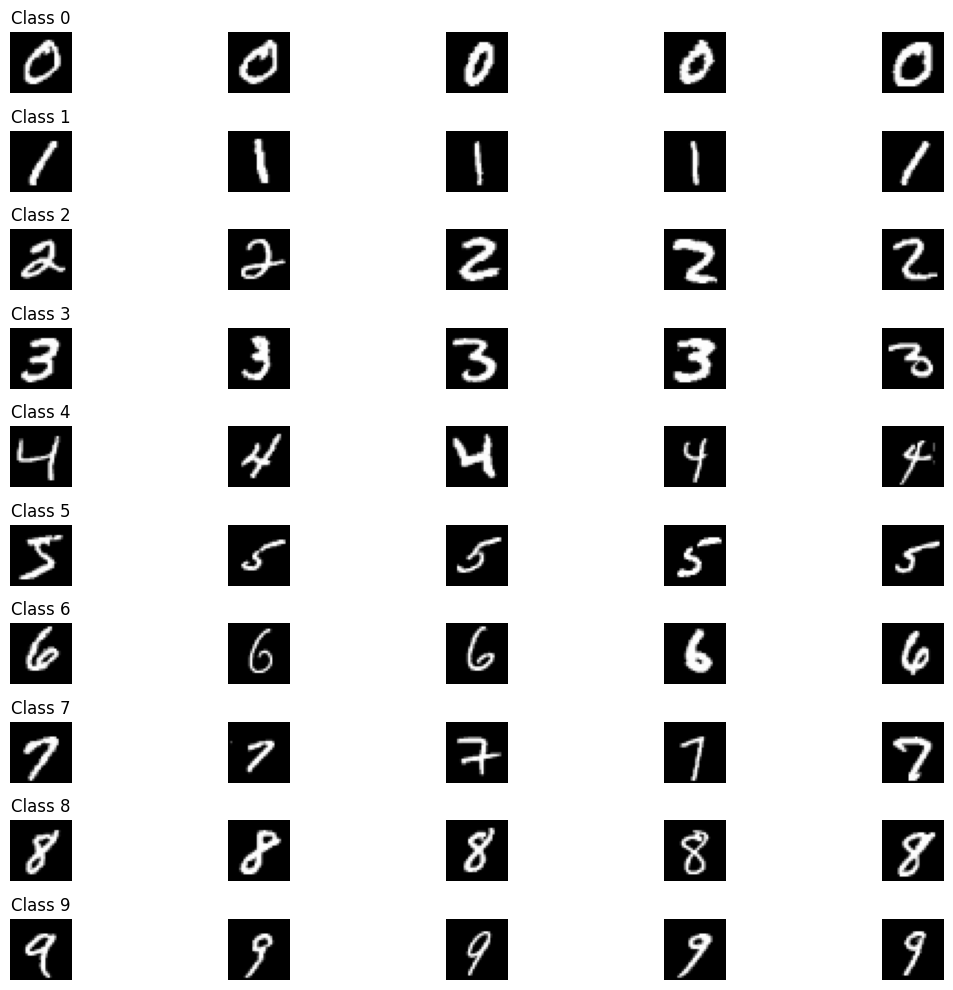

In [96]:
class_labels = list(range(10))
def plot_images_per_class(images, labels, class_labels, num_images=5):
    plt.figure(figsize=(12, 10))
    for i, class_label in enumerate(class_labels):
        indices = np.where(labels == class_label)[0][:num_images]
        for j, idx in enumerate(indices):
            plt.subplot(len(class_labels), num_images, i * num_images + j + 1)
            plt.imshow(images[idx], cmap='gray')
            plt.axis('off')
            if j == 0:
                plt.title(f"Class {class_label}")
    plt.tight_layout()
    plt.show()
plot_images_per_class(training_images, training_labels, class_labels, num_images=5)


5


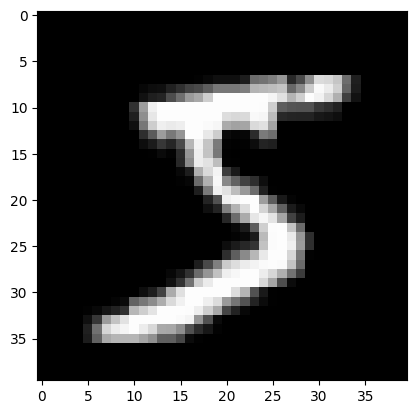

In [97]:
plt.imshow(training_images_rgb[0])
print(training_labels[0])

In [98]:
# Normalisasi dan mengubah dimensi data
training_images = training_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
training_images = training_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]

# Mengonversi label menjadi one-hot encoding
training_labels = tf.keras.utils.to_categorical(training_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

Model ResNet

In [99]:
def resnet_block(inputs, filters, kernel_size, strides):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    if strides > 1:
        inputs = Conv2D(filters=filters, kernel_size=1, strides=strides, padding='same')(inputs)
    x = Add()([x, inputs])
    x = Activation('relu')(x)
    return x

input_shape = (28, 28, 1)
inputs = Input(shape=input_shape)

x = Conv2D(filters=64, kernel_size=7, strides=2, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = AveragePooling2D(pool_size=3, strides=2, padding='same')(x)

x = resnet_block(x, filters=64, kernel_size=3, strides=1)
x = resnet_block(x, filters=64, kernel_size=3, strides=1)
x = resnet_block(x, filters=64, kernel_size=3, strides=1)

x = AveragePooling2D(pool_size=3, strides=2, padding='same')(x)

x = Flatten()(x)
outputs = Dense(units=10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [100]:
# Compile model
model.compile(optimizer= Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Latih model
model.fit(training_images, training_labels, batch_size=64, epochs=10, validation_data=(test_images, test_labels))

# Evaluasi model pada data uji
_, accuracy = model.evaluate(test_images, test_labels)
print('Test Accuracy:', accuracy)


Epoch 1/10
938/938 [==============================] - 41s 42ms/step - loss: 0.1167 - accuracy: 0.9631 - val_loss: 0.1007 - val_accuracy: 0.9659
Epoch 2/10
938/938 [==============================] - 36s 39ms/step - loss: 0.0498 - accuracy: 0.9844 - val_loss: 0.0714 - val_accuracy: 0.9785
Epoch 3/10
938/938 [==============================] - 35s 37ms/step - loss: 0.0379 - accuracy: 0.9880 - val_loss: 0.1223 - val_accuracy: 0.9625
Epoch 4/10
938/938 [==============================] - 35s 37ms/step - loss: 0.0319 - accuracy: 0.9897 - val_loss: 0.0879 - val_accuracy: 0.9704
Epoch 5/10
938/938 [==============================] - 36s 39ms/step - loss: 0.0281 - accuracy: 0.9913 - val_loss: 0.0852 - val_accuracy: 0.9754
Epoch 6/10
938/938 [==============================] - 34s 37ms/step - loss: 0.0254 - accuracy: 0.9922 - val_loss: 0.0309 - val_accuracy: 0.9910
Epoch 7/10
938/938 [==============================] - 37s 40ms/step - loss: 0.0204 - accuracy: 0.9936 - val_loss: 0.0359 - val_accuracy:

313/313 [==============================] - 4s 10ms/step


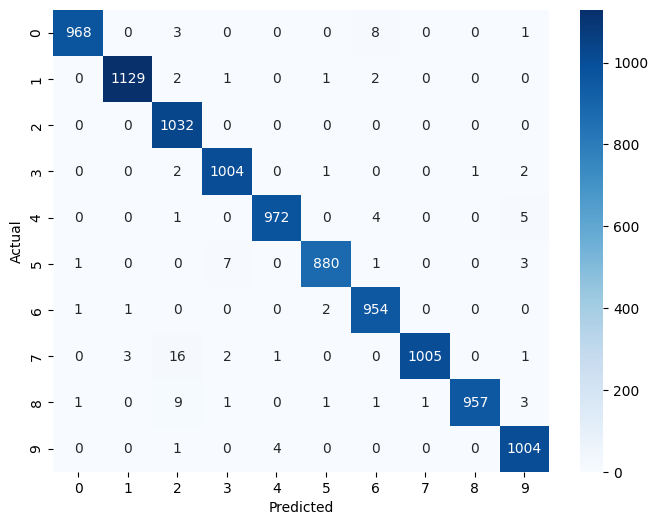

Accuracy:  0.9905
Precision:  0.9906627117460924
Recall:  0.990393384382589
F1:  0.9904726281460162


In [101]:
y_pred = np.argmax(model.predict(test_images), axis=1)
y_true = np.argmax(test_labels, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1: ',  f1)

Klasifikasi untuk data Fashion

In [102]:
# Memuat dataset MNIST
(training_images, training_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [103]:
training_images_rgb = []
for i in range(len(training_images)):
    rgb = to_rgb(training_images[i])
    training_images_rgb.append(rgb)

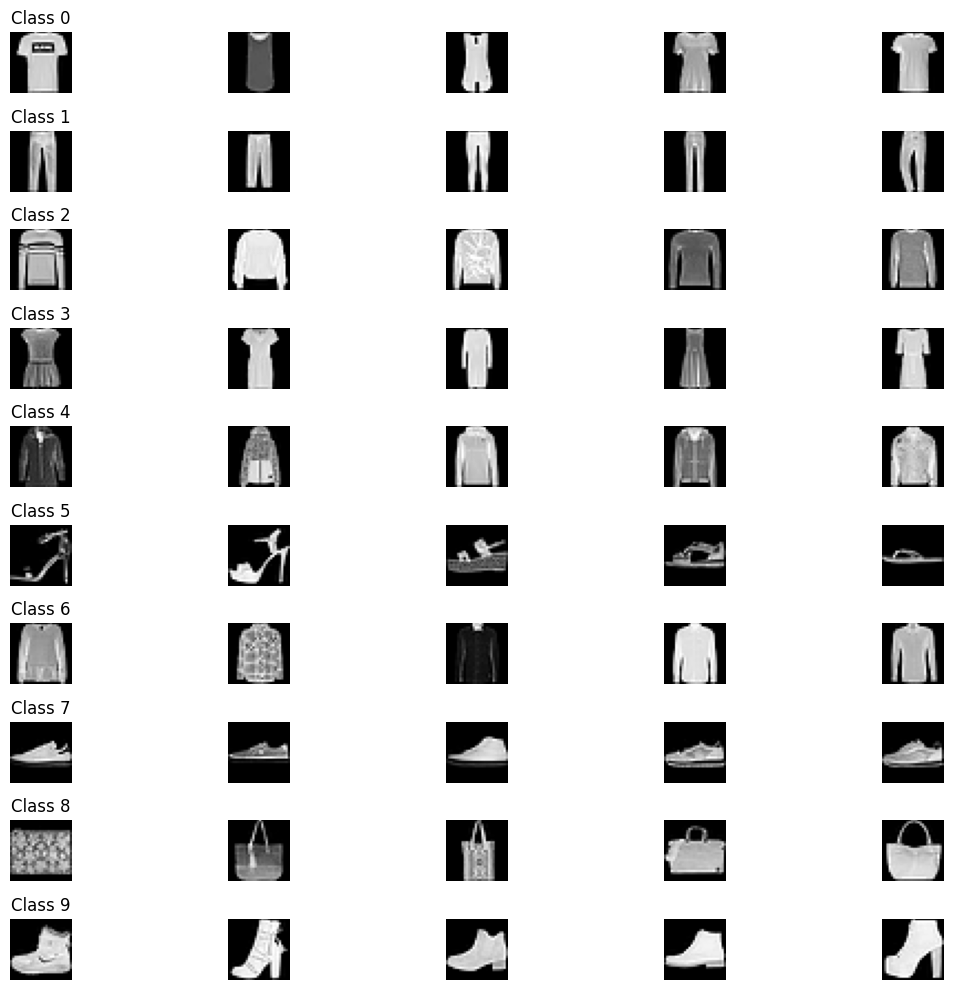

In [104]:
class_labels = list(range(10))
def plot_images_per_class(images, labels, class_labels, num_images=5):
    plt.figure(figsize=(12, 10))
    for i, class_label in enumerate(class_labels):
        indices = np.where(labels == class_label)[0][:num_images]
        for j, idx in enumerate(indices):
            plt.subplot(len(class_labels), num_images, i * num_images + j + 1)
            plt.imshow(images[idx], cmap='gray')
            plt.axis('off')
            if j == 0:
                plt.title(f"Class {class_label}")
    plt.tight_layout()
    plt.show()
plot_images_per_class(training_images, training_labels, class_labels, num_images=5)

9


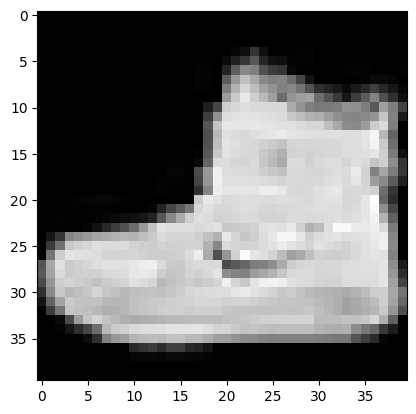

In [105]:
plt.imshow(training_images_rgb[0])
print(training_labels[0])

In [106]:
training_rgb_arr = np.stack([training_images_rgb],axis=4)
training_rgb_arr_to_3d = np.squeeze(training_rgb_arr, axis=4)

In [107]:
test_rgb_arr = np.stack([test_images_rgb],axis=4)
test_rgb_arr_to_3d = np.squeeze(test_rgb_arr, axis=4)

In [108]:
training_rgb_arr_to_3d = training_rgb_arr_to_3d/255.0
test_rgb_arr_to_3d = test_rgb_arr_to_3d/255.0

In [109]:
# Normalisasi dan mengubah dimensi data
training_images = training_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
training_images = training_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]

# Mengonversi label menjadi one-hot encoding
training_labels = tf.keras.utils.to_categorical(training_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

Model ResNet

In [110]:
def resnet_block(inputs, filters, kernel_size, strides):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    if strides > 1:
        inputs = Conv2D(filters=filters, kernel_size=1, strides=strides, padding='same')(inputs)
    x = Add()([x, inputs])
    x = Activation('relu')(x)
    return x

input_shape = (28, 28, 1)
inputs = Input(shape=input_shape)

x = Conv2D(filters=64, kernel_size=7, strides=2, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = AveragePooling2D(pool_size=3, strides=2, padding='same')(x)

x = resnet_block(x, filters=64, kernel_size=3, strides=1)
x = resnet_block(x, filters=64, kernel_size=3, strides=1)
x = resnet_block(x, filters=64, kernel_size=3, strides=1)

x = AveragePooling2D(pool_size=3, strides=2, padding='same')(x)

x = Flatten()(x)
outputs = Dense(units=10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [111]:
# Compile model
model.compile(optimizer= Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Latih model
model.fit(training_images, training_labels, batch_size=64, epochs=10, validation_data=(test_images, test_labels))

# Evaluasi model pada data uji
_, accuracy = model.evaluate(test_images, test_labels)
print('Test Accuracy:', accuracy)


Epoch 1/10
938/938 [==============================] - 42s 43ms/step - loss: 0.4661 - accuracy: 0.8300 - val_loss: 0.4495 - val_accuracy: 0.8436
Epoch 2/10
938/938 [==============================] - 42s 45ms/step - loss: 0.3236 - accuracy: 0.8820 - val_loss: 0.4029 - val_accuracy: 0.8577
Epoch 3/10
938/938 [==============================] - 41s 44ms/step - loss: 0.2855 - accuracy: 0.8953 - val_loss: 0.3181 - val_accuracy: 0.8855
Epoch 4/10
938/938 [==============================] - 41s 43ms/step - loss: 0.2584 - accuracy: 0.9053 - val_loss: 0.3084 - val_accuracy: 0.8874
Epoch 5/10
938/938 [==============================] - 39s 42ms/step - loss: 0.2393 - accuracy: 0.9117 - val_loss: 0.2971 - val_accuracy: 0.8914
Epoch 6/10
938/938 [==============================] - 38s 41ms/step - loss: 0.2201 - accuracy: 0.9187 - val_loss: 0.2965 - val_accuracy: 0.8932
Epoch 7/10
938/938 [==============================] - 38s 41ms/step - loss: 0.2081 - accuracy: 0.9225 - val_loss: 0.3138 - val_accuracy:

313/313 [==============================] - 3s 10ms/step


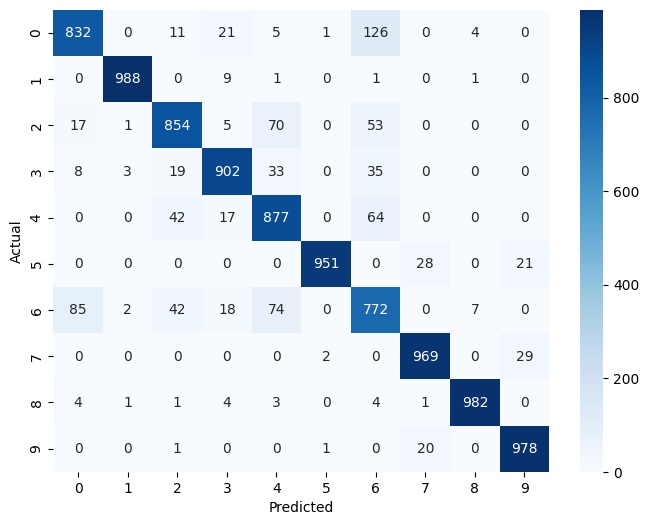

Accuracy:  0.9105
Precision:  0.9120794552529358
Recall:  0.9104999999999999
F1:  0.9109779139830918


In [112]:
y_pred = np.argmax(model.predict(test_images), axis=1)
y_true = np.argmax(test_labels, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1: ',  f1)